# DebruijnExtend Benchmarking Analysis
This python notebook was used for gathering the results from benchmarking DebruijnExtend, parsing the information, and plotting the overall outcomes. 

In [50]:
import os
import glob
from pathlib import Path
from enum import Enum
import numpy as np
from dataclasses import dataclass
from typing import List, Dict
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn3

# PARSERS 
below are the parsers for each of the associated tools. The output format per tool changes, so each tool needs a unique parser

In [51]:
def parser_debext(debExt_dir, extension="ss3", non_test=False):
    """
    This function parses the debext output directory.
    OUTPUT:
        dict = {}
    """
    prediction_outcomes = {}
    for outputfile in glob.glob(debExt_dir+'/*'+extension): #os.listdir(debExt_dir): 
        with open(Path(outputfile)) as resultsfile:
            resultlines = resultsfile.readlines()
            outputfile = Path(outputfile)
            for line_index, line in enumerate(resultlines):
                if line[0] == ">":
                    if non_test:
                        identifier = outputfile.name.split(".")[0]
                    else:
                        identifier = line.strip(">").strip("\n") # uses file name.
                    prediction_outcomes[identifier] = resultlines[line_index+2].strip("\n")
    return prediction_outcomes

def parser_psipred(directory, extension="ss3", non_test=False):
    """
    This function parses the debext output directory.
    OUTPUT:
        dict = {}
    """
    prediction_outcomes = {}
    for outputfile in glob.glob(directory+'/*'+extension):
        with open(Path(outputfile)) as resultsfile:
            resultlines = resultsfile.readlines()
            outputfile = Path(outputfile)
            for line_index, line in enumerate(resultlines):
                if line[0] == ">":
                    if non_test:
                        identifier = outputfile.name.split(".")[0]
                    else:
                        identifier = line.strip(">").strip("\n") # uses file name.
                    prediction_outcomes[identifier] = resultlines[line_index+2].strip("\n")
    return prediction_outcomes

def parser_porter5(directory, extension="ss3", non_test=False):
    """
    This function parses the debext output directory.
    OUTPUT:
        dict = {}
    """
    prediction_outcomes = {}
    for outputfile in glob.glob(directory+'/*'+extension):
        with open(Path(outputfile)) as resultsfile:
            resultlines = resultsfile.readlines()
            outputfile = Path(outputfile)
            protein = []
            for line_index, line in enumerate(resultlines):
                line = line.split("\t")
                if (line_index > 0):
                    protein.append(line[2])
                    #prediction_outcomes[identifier] = resultlines[line_index+2].strip("\n")
            identifier = outputfile.name.split(".")[0]
            prediction_outcomes[identifier] = ''.join(protein)
    return prediction_outcomes

def parser_spider(directory, extension="spd3", non_test=False):
    """
    This function parses the debext output directory.
    OUTPUT:
        dict = {}
    """
    prediction_outcomes = {}
    for outputfile in glob.glob(directory+'/*'+extension):
        with open(Path(outputfile)) as resultsfile:
            resultlines = resultsfile.readlines()
            outputfile = Path(outputfile)
            protein = []
            for line_index, line in enumerate(resultlines):
                line = line.split("\t")
                if (line_index > 0):
                    protein.append(line[2])
                    #prediction_outcomes[identifier] = resultlines[line_index+2].strip("\n")
            identifier = outputfile.name.split(".")[0]
            prediction_outcomes[identifier] = ''.join(protein)
    return prediction_outcomes

# Gathering Results
The functions below are used for each tool.

In [52]:
class ResultStruct:
    """ datastruct for holding results """
    
    def __init__(self):
        self.accuracy : list = []
        self.length : list = []
        self.conf_matrix = np.zeros((3,3))

def parse_dir(directory, truth_csv, parser_function):
    """
    This function parses all files within an output
    folder for DebruijnExtend.

    OUTPUT:                                                                     
        results = { "accuracy" : [[.8, .4, ..., 0.7], # percent guessed correctly  
                    "length" : [254, 223, ..., 30], # length per                
                    "conf_matrix" : [[],[],[]] # confusion matrix}
    """
    #results_dict = {test_iteration : [[], [], np.zeros((3,3))] }
    results: ResultStruct = ResultStruct()
    seq_dict = parser_function(directory) ### CHANGE
    truth_dict = parse_truth(truth_csv)
    for identifier, prediction in seq_dict.items():
        true_ss3 = truth_dict[identifier]
        accuracy, confusion_matrix = prediction_rank(prediction, true_ss3)
        # append results to dictinoary
        results.accuracy.append(accuracy)
        results.length.append(accuracy)
        results.conf_matrix += confusion_matrix
    return results
    
def parse_truth(truth_csv, parsing_index=3):
    """
    parses the truth CSV to get the actual ss3
    """
    truth_dict = {}
    with open(truth_csv) as file_by_lines:
        file_lines = file_by_lines.readlines()
        for index, line in enumerate(file_lines):
            identifier = line.split(",")[parsing_index-2].strip("\n").strip("'")
            truth_dict[identifier] = line.split(",")[parsing_index].strip("\n").strip("'") #TODO: ASSUMES SAME ORDER AS FASTA!!
    return truth_dict

def prediction_rank(prediction, true):                                 
    """                                                                         
    This function scores the accuracy of a prediction.     
                                                                                
    INPUT: 1. an input prediction sequence
           2. the true secondary structure sequence
    OUTPUT: 1. percent guessed correctly (range: 0-1)
            2. confusion matrix
    """
    # init
    confusion_matrix = [[0,0,0],[0,0,0],[0,0,0]]
    map_dict = {"C" : 0, "E" : 1, "H" : 2}
    prediction_array = np.zeros((len(true)))
    # iterate through predicted and true
    for index in range(len(prediction)):
        # update prediction_array
        if prediction[index] == true[index]:
            prediction_array[index] = 1
        # update confusion matrix
        if (true[index] in map_dict.keys()) and (prediction[index] in map_dict.keys()):
            true_ind = map_dict[true[index]]
            pred_ind = map_dict[prediction[index]]
            confusion_matrix[true_ind][pred_ind] += 1
    # calculate the accuracy
    accuracy = round(sum(prediction_array) / len(prediction_array), 4)

    return accuracy, confusion_matrix 

In [53]:
def plot_confusion_matrix(input_results: ResultStruct):                                                        
    """                                                                         
    This function plot the confusion matrix 
    """ 
    total_confusion = input_results.conf_matrix
    # turn array into pandas dataframe
    total_confusion = pd.DataFrame(total_confusion, 
                                   columns=['C', 'E', 'H'], 
                                   index=['C', 'E', 'H'])
    ## plot confusion matrix
    ax = sns.heatmap(total_confusion, annot=True, linewidths=.5)
    
    plt.show()

def avg_acc_per_length(input_results: ResultStruct):
    """
    This plots a scatter plot for a particular software. The scatterplot 
    shows accuracy vs length
    """
    total_accuracy_array = input_results.accuracy
    total_length_array = input_results.length
    # plot
    plt.scatter(total_length_array, total_accuracy_array, color="orange", edgecolor="b")
    plt.ylim(0, 1)
    plt.ylabel("Accuracy")
    plt.xlabel("Protein Length")
    
    plt.show()

def difference_vendiagram(input_results_dict, threshold=0.9):
    """
    This function plots a vendiagram of the tools for all of the predictions.
    """
    results = []
    for software_name, software_i in multi_input_results.items():
        accuracy_array = list(multi_input_results[software_name].accuracy)
        correct_set = []
        for index, result in enumerate(accuracy_array):
            if (result < threshold):
                correct_set.append(str(index))
        results.append(set(correct_set))
    venn3(results, (software for software in input_results_dict.keys()))
    plt.title(f"Shared proteins with less than {threshold}% accuracy")
    
    plt.show()

def plot_bar(multi_input_results):
    """
    This method plots a simple bar graph for the data.
    input: list of dicts per software.
    """
    N = 1
    fig, ax = plt.subplots()
    # create array with means and STDs
    meadSTD = []
    for software_name, software_i in multi_input_results.items():
        accuracy_array = list(multi_input_results[software_name].accuracy)
        meadSTD.append(accuracy_array)
    meadSTD = np.array(meadSTD, dtype=object).transpose()
    meadSTD_df = pd.DataFrame(meadSTD) #, columns=multi_input_results.keys(), index=['mean', 'STD'])
    ax = sns.violinplot(data=meadSTD_df, scale="width")
    ax.set_title('Secondary Structure Prediction Accuracy')
    ax.set_ylabel('Q3 Accuracy')
    ax.set_xticklabels(multi_input_results.keys(), rotation='vertical')

    plt.show()
    

# Benchmarking

This script parses the output from all of the tools and gathers acccuracies per protein.

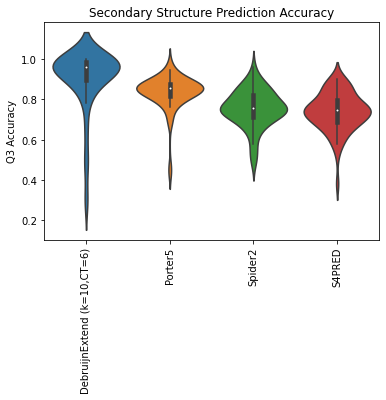

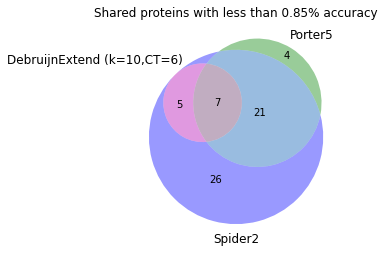

In [54]:
# PATHS
prev_path = "../../benchmarking/tools/"
bench_suffix = "FinalizedBenchmarking/"
debExt_dir_3 = prev_path+"debext_"+bench_suffix
psipred_dir = prev_path+"s4pred_"+bench_suffix
porter5_dir = prev_path+"porter5_"+bench_suffix
spider_dir = prev_path+"spider2_"+bench_suffix
truth_csv = prev_path+"TESTING2.csv"

########
# obtan results dictionaries.
########
debExt_dir_3r = parse_dir(debExt_dir_3, truth_csv, parser_function=parser_debext)
psipred_result = parse_dir(psipred_dir, truth_csv, parser_function=parser_psipred)
porter5_result = parse_dir(porter5_dir, truth_csv, parser_function=parser_porter5)
spider_result = parse_dir(spider_dir, truth_csv, parser_function=parser_spider)

########
# obtain plots.
########

# Create results dictionary
multi_input_results = {"DebruijnExtend (k=10,CT=6)" : debExt_dir_3r, 
                       "Porter5" : porter5_result,
                       "Spider2" : spider_result,
                       "S4PRED" : psipred_result,
                      }
# for results in multi_input_results.values():
#     print(sorted(results.accuracy))
#     print(np.average(results.accuracy))

# plot the violin plots for all of the results
plot_bar(multi_input_results)

# plot shared error proteins between top 3 tools
del multi_input_results["S4PRED"]
difference_vendiagram(multi_input_results, threshold=0.85)

[0.4853, 0.6889, 0.6238, 0.5291, 0.5906]
[0.5941, 0.7492, 0.6584, 0.6633, 0.6199]
[0.9, 0.8266, 0.8465, 0.8878, 0.8158]
[0.9647, 0.935, 0.995, 0.976, 1.0]
[0.9735, 0.743, 1.0, 0.98, 1.0]
[0.9824, 0.7477, 1.0, 0.984, 1.0]
[0.9853, 0.7477, 1.0, 0.986, 0.9971]
[0.9853, 0.7492, 1.0, 0.984, 1.0]
[1.0, 0.9752, 1.0, 0.992, 1.0]
[1.0, 0.9876, 1.0, 1.0, 1.0]
[1.0, 0.9752, 1.0, 0.992, 1.0]
[1.0, 0.9876, 1.0, 1.0, 1.0]


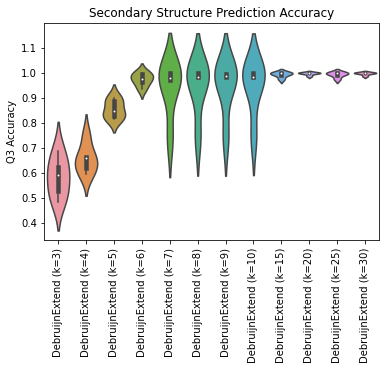

In [58]:
# PATHS
prev_path = "../../benchmarking/tools/"
debExt_dir_3 = prev_path+"debext_output_k3"
debExt_dir_4 = prev_path+"debext_output_k4"
debExt_dir_5 = prev_path+"debext_output_k5"
debExt_dir_6 = prev_path+"debext_output_k6"
debExt_dir_7 = prev_path+"debext_output_k7"
debExt_dir_8 = prev_path+"debext_output_k8"
debExt_dir_9 = prev_path+"debext_output_k9"
debExt_dir_10 = prev_path+"debext_output_k10"
debExt_dir_15 = prev_path+"debext_output_k15"
debExt_dir_20 = prev_path+"debext_output_k20"
debExt_dir_25 = prev_path+"debext_output_k25"
debExt_dir_30 = prev_path+"debext_output_k30"
truth_csv = prev_path+"TESTING.csv"

########
# obtan results dictionaries.
########
debExt_dir_3r = parse_dir(debExt_dir_3, truth_csv, parser_debext)
debExt_dir_4r = parse_dir(debExt_dir_4, truth_csv, parser_debext)
debExt_dir_5r = parse_dir(debExt_dir_5, truth_csv, parser_debext)
debExt_dir_6r = parse_dir(debExt_dir_6, truth_csv, parser_debext)
debExt_dir_7r = parse_dir(debExt_dir_7, truth_csv, parser_debext)
debExt_dir_8r = parse_dir(debExt_dir_8, truth_csv, parser_debext)
debExt_dir_9r = parse_dir(debExt_dir_9, truth_csv, parser_debext)
debExt_dir_10r = parse_dir(debExt_dir_10, truth_csv, parser_debext)
debExt_dir_15r = parse_dir(debExt_dir_15, truth_csv, parser_debext)
debExt_dir_20r = parse_dir(debExt_dir_20, truth_csv, parser_debext)
debExt_dir_25r = parse_dir(debExt_dir_25, truth_csv, parser_debext)
debExt_dir_30r = parse_dir(debExt_dir_30, truth_csv, parser_debext)

########
# obtain plots.
########
multi_input_results = {"DebruijnExtend (k=3)" : debExt_dir_3r,
                       "DebruijnExtend (k=4)" : debExt_dir_4r,
                       "DebruijnExtend (k=5)" : debExt_dir_5r,
                       "DebruijnExtend (k=6)" : debExt_dir_6r,
                       "DebruijnExtend (k=7)" : debExt_dir_7r, 
                       "DebruijnExtend (k=8)" : debExt_dir_8r,
                       "DebruijnExtend (k=9)" : debExt_dir_9r,
                       "DebruijnExtend (k=10)" : debExt_dir_10r,
                       "DebruijnExtend (k=15)" : debExt_dir_15r,
                       "DebruijnExtend (k=20)" : debExt_dir_20r,
                       "DebruijnExtend (k=25)" : debExt_dir_25r,
                       "DebruijnExtend (k=30)" : debExt_dir_30r}

# print accuracy
for results in multi_input_results.values():
    print(results.accuracy)
    
# make violin plots
plot_bar(multi_input_results)

[[1.]]
CCCCCCCEEECCCCCCCCCCCEEEEEECCEEEEEEECCCCCCCHHCCCEEEECCCCCEEEECCCEEECCCCCEEECCEEEEEEEECCCEEEEECCCCCEEEEEECEEEECCCCCEECCCCCEEEEEECCCCCCHHHHHHHHCCEEEECCCCCCCCCCEEEECCCEEEEEEEEEEECCCEEEEEECCCCCEEEEEEEECCCCCEEECCCCCCCCCCCCHHHHEHHHCCCCCCCCCCCCCCCEECCCCCECCCCCCCCCCCCCEEEEEEEEEEEEECCCCCCEEEEEECCEEEEEECCCCCCCCCCCEEEEECCCCCCCCCCEEECCCCCCCCCCHHHHHHCCCCCCCCCCEEEEEEECCCCCCCEEEEECCCCCCCCCEEEEECCCEEEEEECCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCHHCCCEEECCCEEEEECCCCCCEEEEEEEEEECCCCCCEEEECCCEEEEEEEEECCCCCCCCCEEEEECCEEECCEEEEEEEECCCCCEEEECCCCEECCCCCCCCHHHEEECCCCCCCCCEEEEEECCCCCEEEEEEEEECCCCECCCCEEEEECCCCCCCCCEEEEEEECCCCCCEEEEEECCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCEEEEEEECCCCCEEEEEEEEC
CCCCCCCCCEEEEEEECCCCCCCCCCEEEEEEECCCCCCCCCCCCCCCCCCCCCEEECCCCCCCCCCCCCCCCCCCCCCCEEEEEECCCCCCCCEEEEECCCEECCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCHCCCCCCCCCCCCHHHHHHCCCCCEEEEEECCCCCCEEEEEEEEECCCCCCHHHHHHHHHHHHCCCCCCCCCCCCHHHHHHHHHHHHHHHHHHHHHCCCCCHHHHHHHHHHHHHHHHHHHHHCCCHHHHHHHHHHHHHHCCHHHHHHHHHHHHHHHHCCCCCC

(array([31., 19.,  8.,  2.,  1.,  2.,  1.,  0.,  0.,  1.]),
 array([ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54., 60.]),
 <BarContainer object of 10 artists>)

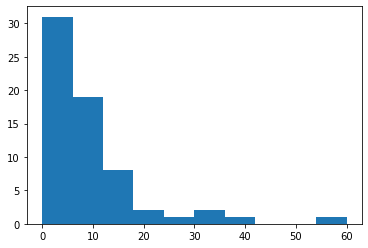

In [61]:
prev_path = "../../benchmarking/tools/"
p_debext = prev_path+"debext_spike_proteins"
p_p4pred = prev_path+"s4pred_spike_proteins"
p_porter5 = prev_path+"porter5_spike_proteins"
p_spider = prev_path+"spider2_spike_proteins"


############
# Parsing output
############
phage_debExt = parser_debext(p_debext, non_test=True)
phage_psipred = parser_psipred(p_p4pred,non_test=True)
phage_porter5 = parser_porter5(p_porter5, non_test=True)
phage_spider = parser_spider(p_spider, non_test=True)

############
# Similiariity matrix between tools
############
tool_predictions = [phage_psipred]#, phage_porter5, phage_spider, phage_debExt]
similiarity_matrix = np.zeros((len(tool_predictions), 
                               len(tool_predictions)))
for row, tool_1 in enumerate(tool_predictions):
    for col, tool_2 in enumerate(tool_predictions):
        # look through predictions
        for sequence_name, prediction_1 in tool_1.items():
            prediction_2 = tool_2[sequence_name]
            try:
                accuracy = prediction_rank(prediction_1, prediction_2)[0]
            except:
                accuracy = 90
            similiarity_matrix[row][col] += accuracy
        similiarity_matrix[row][col] /= len(tool_1.items())
        
print(similiarity_matrix)
# print(phage_porter5[0])

############
# structure lengths
############
for row, tool in enumerate(tool_predictions):
    count_dict = {'C' : [], 'E': [], 'H' : []}
    for prediction in tool.values():
        print(prediction)
        last_ss3 = None
        length = 0 
        #print(prediction)
        for ss3 in prediction:
            if last_ss3 != None:
                #print(ss3, last_ss3, length)
                if (ss3 == last_ss3):
                    length += 1
                else:
                    count_dict[ss3].append(length)
                    length = 1
                    last_ss3 = ss3
            else:
                last_ss3 = ss3
                length += 1
       
    for ss3 in ['C', 'E', 'H']:
        avg = np.average(count_dict[ss3])
        std = np.std(count_dict[ss3])
        print(f"{ss3}, {avg}, {std}")

plt.hist(count_dict['H'], bins=10, range=(0,60))

In [ ]:
[phage_psipred, phage_porter5, phage_spider, phage_debExt]
C, 9.389380530973451, 8.916955737035938, phage_debExt
C, 4.947368421052632, 3.599449955972078, phage_spider
C, 6.158357771260997, 9.095686948040289, PORTER5
C, 5.768976897689769, 3.5903374097204153, phage_psipred

In [ ]:
[phage_psipred, phage_porter5, phage_spider, phage_debExt]
H, 30.977272727272727, 36.93082516147504, DebriujnExtend
H, 4.86231884057971, 4.739889359965852, SPIDER
H, 6.934426229508197, 8.164033181310664, PORTER5
H, 11.484848484848484, 22.005675868547836, P4PRED

In [ ]:
[phage_psipred, phage_porter5, phage_spider, phage_debExt]
E, 28.044776119402986, 25.138679738198828, DebriujnExtend
E, 4.663608562691132, 3.9465065811931304, SPIDER
E, 6.336805555555555, 5.416772390349997, PORTER5
E, 7.2, 6.200822209871153, P4PRED